# Train siamese network 

The code here is based on example code from the a modern CV course from Udemy. I modified the code to apply it to the case of cyrillic letters.

In [32]:
import pandas as pd
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


In [33]:
df = pd.read_csv("train.csv")

labels = ['А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ё', 'Ж', 'З', 'И', 'Й',
          'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф',
          'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']

In [34]:
df

,filename,letters81,merged53,unbalanced42class,balanced42,Russian
0,25_25_339_20190729091515.png,67,25,25,25.0,20.0
1,20_38_200_20190729104200.png,20,20,20,20.0,-1.0
2,23_23_1151_20190729091009.png,65,23,23,23.0,18.0
3,33_33_983_20190729110743.png,33,33,33,33.0,25.0
4,27_27_747_20190729105344.png,27,27,27,27.0,-1.0
...,...,...,...,...,...,...
96982,14_14_754_20190729103127.png,14,14,14,-1.0,-1.0
96983,8_37_480_20190730082651.png,8,8,8,-1.0,6.0
96984,13_13_538_20190729102805.png,13,13,13,-1.0,11.0
96985,3_3_103_20190729082254.png,45,44,3,-1.0,2.0


In [35]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,df,transform=None,should_invert=True, letter=0):
        self.df = df
        self.transform = transform
        self.should_invert = should_invert
        self.letter = letter
        self.reffiles = list(self.df.query(f'Russian == {self.letter}').filename)
        self.otherfiles = list(self.df.query(f'Russian != {self.letter}').filename)

    def __getitem__(self,index):
        
        img0 = random.choice(self.reffiles)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        label = 0
        if should_get_same_class:
            img1 = random.choice(self.reffiles) 
            label = 0
        else:
            img1 = random.choice(self.otherfiles)
            label = 1

        img0 = Image.open(f'allgr/{img0}')
        img1 = Image.open(f'allgr/{img1}')
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return np.array(img0),np.array(img1) , label
    
    def __len__(self):
        return 10000

In [36]:
dfrussian = df.query('Russian > -1 and letters81 <= 41 ')

In [37]:
siamese_dataset = SiameseNetworkDataset(dfrussian,letter=5,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()]),
                                                                      should_invert=False)

In [38]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

In [39]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=4,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)



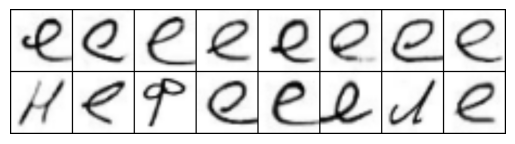

[1 0 1 0 0 0 1 0]


In [40]:
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [41]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),)

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [42]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [43]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=32)

In [44]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [48]:
counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(0,50):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
            

Epoch number 0
 Current loss 1.1466953754425049

Epoch number 0
 Current loss 1.0780680179595947

Epoch number 0
 Current loss 1.0471539497375488

Epoch number 0
 Current loss 1.0569581985473633

Epoch number 0
 Current loss 1.1393697261810303

Epoch number 0
 Current loss 1.0784704685211182

Epoch number 0
 Current loss 1.1605868339538574

Epoch number 0
 Current loss 1.1012439727783203

Epoch number 0
 Current loss 0.9805384874343872

Epoch number 0
 Current loss 1.0727570056915283

Epoch number 0
 Current loss 1.1346449851989746

Epoch number 0
 Current loss 1.123971939086914

Epoch number 0
 Current loss 1.0356802940368652

Epoch number 0
 Current loss 1.1235157251358032

Epoch number 0
 Current loss 1.2323716878890991

Epoch number 0
 Current loss 1.215531587600708

Epoch number 0
 Current loss 1.0644118785858154

Epoch number 0
 Current loss 1.1671397686004639

Epoch number 0
 Current loss 1.1210393905639648

Epoch number 0
 Current loss 1.0814342498779297

Epoch number 0
 Curren

Epoch number 5
 Current loss 1.0510128736495972

Epoch number 5
 Current loss 1.1774312257766724

Epoch number 5
 Current loss 1.1288177967071533

Epoch number 5
 Current loss 1.1567165851593018

Epoch number 5
 Current loss 1.1217848062515259

Epoch number 5
 Current loss 1.0977330207824707

Epoch number 5
 Current loss 1.1559484004974365

Epoch number 5
 Current loss 1.0419447422027588

Epoch number 5
 Current loss 1.0684945583343506

Epoch number 5
 Current loss 1.0841084718704224

Epoch number 5
 Current loss 1.1286545991897583

Epoch number 5
 Current loss 1.0925166606903076

Epoch number 5
 Current loss 1.2383840084075928

Epoch number 5
 Current loss 1.1099505424499512

Epoch number 5
 Current loss 1.10146963596344

Epoch number 5
 Current loss 1.116023063659668

Epoch number 5
 Current loss 1.0568913221359253

Epoch number 5
 Current loss 1.1478888988494873

Epoch number 5
 Current loss 1.124103307723999

Epoch number 5
 Current loss 1.0817866325378418

Epoch number 5
 Current 

Epoch number 10
 Current loss 1.1226071119308472

Epoch number 10
 Current loss 1.0901305675506592

Epoch number 10
 Current loss 2.590106248855591

Epoch number 10
 Current loss 1.0819218158721924

Epoch number 10
 Current loss 1.116576075553894

Epoch number 10
 Current loss 1.0651381015777588

Epoch number 10
 Current loss 1.0765972137451172

Epoch number 10
 Current loss 1.0904736518859863

Epoch number 10
 Current loss 1.0798171758651733

Epoch number 10
 Current loss 1.052791714668274

Epoch number 10
 Current loss 1.1625840663909912

Epoch number 10
 Current loss 1.0734398365020752

Epoch number 10
 Current loss 1.1245317459106445

Epoch number 10
 Current loss 1.0137823820114136

Epoch number 10
 Current loss 1.0541901588439941

Epoch number 11
 Current loss 1.0355452299118042

Epoch number 11
 Current loss 1.052494764328003

Epoch number 11
 Current loss 1.0774438381195068

Epoch number 11
 Current loss 1.034600019454956

Epoch number 11
 Current loss 1.053398609161377

Epoch 

Epoch number 15
 Current loss 0.9437389373779297

Epoch number 15
 Current loss 1.0006392002105713

Epoch number 15
 Current loss 1.037444829940796

Epoch number 15
 Current loss 1.005829095840454

Epoch number 15
 Current loss 1.024688720703125

Epoch number 15
 Current loss 1.017888069152832

Epoch number 15
 Current loss 0.9997289180755615

Epoch number 15
 Current loss 0.9745804071426392

Epoch number 15
 Current loss 1.0021647214889526

Epoch number 15
 Current loss 1.0826271772384644

Epoch number 16
 Current loss 1.156651496887207

Epoch number 16
 Current loss 1.0842316150665283

Epoch number 16
 Current loss 1.1080162525177002

Epoch number 16
 Current loss 1.0799646377563477

Epoch number 16
 Current loss 1.1110384464263916

Epoch number 16
 Current loss 1.0580910444259644

Epoch number 16
 Current loss 1.1867551803588867

Epoch number 16
 Current loss 1.0518968105316162

Epoch number 16
 Current loss 1.0847080945968628

Epoch number 16
 Current loss 1.0628690719604492

Epoch

Epoch number 20
 Current loss 1.170592188835144

Epoch number 20
 Current loss 1.0636875629425049

Epoch number 20
 Current loss 1.0772793292999268

Epoch number 20
 Current loss 1.0425357818603516

Epoch number 20
 Current loss 1.0287991762161255

Epoch number 21
 Current loss 1.0794212818145752

Epoch number 21
 Current loss 1.0987135171890259

Epoch number 21
 Current loss 1.0777051448822021

Epoch number 21
 Current loss 1.0314342975616455

Epoch number 21
 Current loss 1.092514991760254

Epoch number 21
 Current loss 1.1518611907958984

Epoch number 21
 Current loss 1.0916749238967896

Epoch number 21
 Current loss 1.0848407745361328

Epoch number 21
 Current loss 1.102726936340332

Epoch number 21
 Current loss 1.050455093383789

Epoch number 21
 Current loss 1.1331100463867188

Epoch number 21
 Current loss 1.138871192932129

Epoch number 21
 Current loss 1.051772952079773

Epoch number 21
 Current loss 1.0506691932678223

Epoch number 21
 Current loss 0.9687712788581848

Epoch 

Epoch number 26
 Current loss 1.0198450088500977

Epoch number 26
 Current loss 0.9197518229484558

Epoch number 26
 Current loss 0.9587874412536621

Epoch number 26
 Current loss 1.0091105699539185

Epoch number 26
 Current loss 1.0188062191009521

Epoch number 26
 Current loss 1.0421102046966553

Epoch number 26
 Current loss 1.0264160633087158

Epoch number 26
 Current loss 1.0153477191925049

Epoch number 26
 Current loss 0.9387434124946594

Epoch number 26
 Current loss 1.0120935440063477

Epoch number 26
 Current loss 1.0356652736663818

Epoch number 26
 Current loss 1.0747218132019043

Epoch number 26
 Current loss 1.1975510120391846

Epoch number 26
 Current loss 0.9935622215270996

Epoch number 26
 Current loss 1.0332900285720825

Epoch number 26
 Current loss 1.0261867046356201

Epoch number 26
 Current loss 0.9803110361099243

Epoch number 26
 Current loss 1.069396734237671

Epoch number 26
 Current loss 1.0121432542800903

Epoch number 26
 Current loss 1.0135270357131958

E

Epoch number 31
 Current loss 1.0578970909118652

Epoch number 31
 Current loss 0.9551897644996643

Epoch number 31
 Current loss 0.9699122905731201

Epoch number 31
 Current loss 0.9551717042922974

Epoch number 31
 Current loss 1.0418708324432373

Epoch number 31
 Current loss 1.022077202796936

Epoch number 31
 Current loss 1.0043549537658691

Epoch number 31
 Current loss 0.916717529296875

Epoch number 31
 Current loss 1.0316119194030762

Epoch number 31
 Current loss 1.0205810070037842

Epoch number 31
 Current loss 1.0141119956970215

Epoch number 31
 Current loss 1.0270322561264038

Epoch number 31
 Current loss 1.0567749738693237

Epoch number 31
 Current loss 1.0140736103057861

Epoch number 31
 Current loss 0.9612461924552917

Epoch number 31
 Current loss 0.9170618653297424

Epoch number 31
 Current loss 1.0061321258544922

Epoch number 31
 Current loss 1.0099713802337646

Epoch number 31
 Current loss 1.0104632377624512

Epoch number 31
 Current loss 0.9802234172821045

Ep

Epoch number 36
 Current loss 0.83891761302948

Epoch number 36
 Current loss 0.9926385879516602

Epoch number 36
 Current loss 1.0185275077819824

Epoch number 36
 Current loss 1.008310317993164

Epoch number 36
 Current loss 0.9822418689727783

Epoch number 36
 Current loss 1.0296351909637451

Epoch number 36
 Current loss 1.0139949321746826

Epoch number 36
 Current loss 0.977418065071106

Epoch number 36
 Current loss 1.0122158527374268

Epoch number 36
 Current loss 1.0517914295196533

Epoch number 36
 Current loss 0.9868714213371277

Epoch number 36
 Current loss 0.9925611019134521

Epoch number 36
 Current loss 0.920810878276825

Epoch number 36
 Current loss 1.0628670454025269

Epoch number 36
 Current loss 1.0113556385040283

Epoch number 36
 Current loss 1.1771318912506104

Epoch number 36
 Current loss 1.0349524021148682

Epoch number 36
 Current loss 0.9808270335197449

Epoch number 36
 Current loss 1.0494558811187744

Epoch number 36
 Current loss 1.0280627012252808

Epoch

Epoch number 41
 Current loss 0.9018998742103577

Epoch number 41
 Current loss 0.9964732527732849

Epoch number 41
 Current loss 1.013749361038208

Epoch number 41
 Current loss 0.9944897890090942

Epoch number 41
 Current loss 1.0141210556030273

Epoch number 41
 Current loss 1.0549198389053345

Epoch number 41
 Current loss 1.006723403930664

Epoch number 41
 Current loss 1.0093079805374146

Epoch number 41
 Current loss 0.9645159840583801

Epoch number 41
 Current loss 1.0132073163986206

Epoch number 41
 Current loss 0.9296574592590332

Epoch number 41
 Current loss 1.0185937881469727

Epoch number 41
 Current loss 0.979107141494751

Epoch number 41
 Current loss 0.987074077129364

Epoch number 41
 Current loss 0.951393723487854

Epoch number 41
 Current loss 0.9959705471992493

Epoch number 41
 Current loss 1.0079975128173828

Epoch number 42
 Current loss 1.0764747858047485

Epoch number 42
 Current loss 1.4815739393234253

Epoch number 42
 Current loss 0.9664055109024048

Epoch

Epoch number 46
 Current loss 0.9947137832641602

Epoch number 46
 Current loss 1.1799535751342773

Epoch number 46
 Current loss 1.044241189956665

Epoch number 46
 Current loss 1.0135713815689087

Epoch number 46
 Current loss 1.0712225437164307

Epoch number 46
 Current loss 1.013870358467102

Epoch number 46
 Current loss 0.9952106475830078

Epoch number 46
 Current loss 1.0234402418136597

Epoch number 46
 Current loss 1.0050828456878662

Epoch number 46
 Current loss 0.988756537437439

Epoch number 46
 Current loss 1.0426464080810547

Epoch number 46
 Current loss 1.016996145248413

Epoch number 47
 Current loss 1.0537818670272827

Epoch number 47
 Current loss 1.0268895626068115

Epoch number 47
 Current loss 1.0227112770080566

Epoch number 47
 Current loss 1.0421961545944214

Epoch number 47
 Current loss 1.0200448036193848

Epoch number 47
 Current loss 1.000251054763794

Epoch number 47
 Current loss 0.9933153986930847

Epoch number 47
 Current loss 1.1822513341903687

Epoch

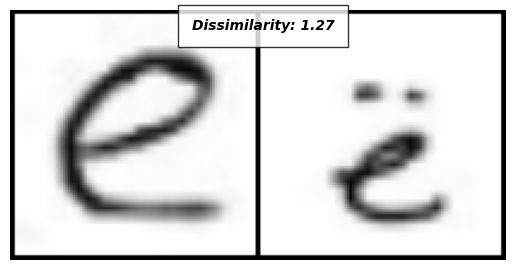

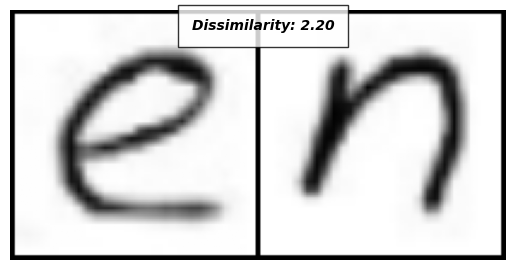

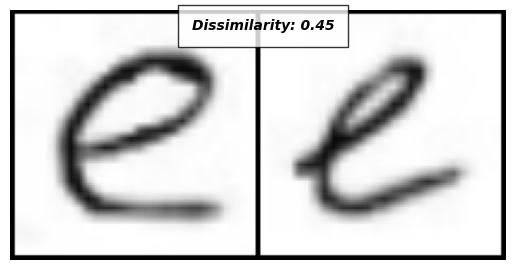

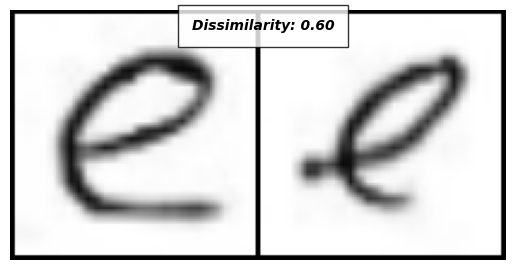

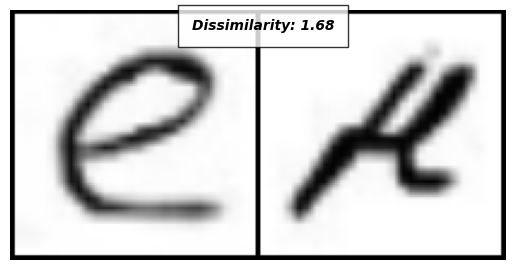

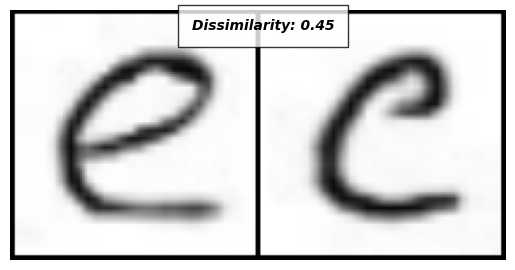

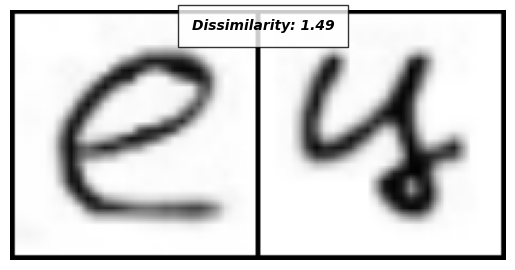

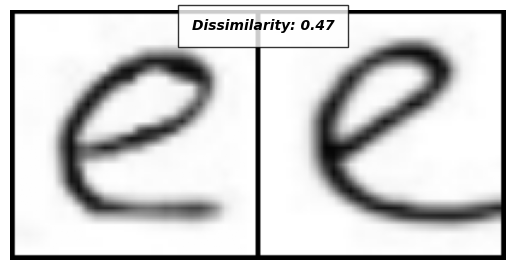

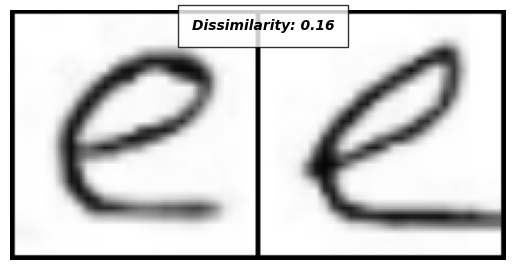

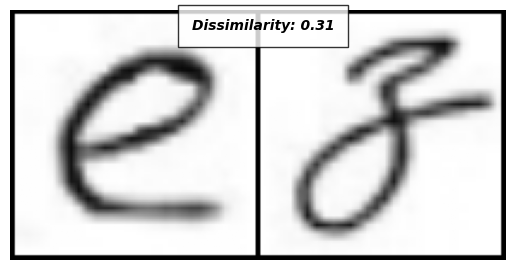

In [49]:

df = pd.read_csv("test.csv")
dfrussian = df.query('Russian > -1 and letters81 <= 41 ')

siamese_dataset = SiameseNetworkDataset(dfrussian,letter=5,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()]),
                                                                      should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))